In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
from scipy import io as sio, ndimage

import process.file as f
import process.atlas as atl
import utils.utils as uti


In [16]:
df_data = f.proc_FOCO('data/NP_FOCO_cropped/2022-02-12-w01-NP1')
atlas = atl.Atlas()
neuron_dict = atlas.create_dictionary()
df_atlas = atlas.get_df()

### Run on all datasets and calc costs

In [ ]:
def calc_loss_grad(A, b, data):
    loss = 0
    dz_tot = 0
    A_grad = 0
    tot = len(data)
    for i, row in data.iterrows():
        C = row['rgb data']
        mu = row['rgb mu']
        sig = row['rgb sigma']
        z = A @ C + b - mu
        B = np.linalg.inv(sig)
        loss += z.T @ B @ z # should be scalar

        dz = 2*B@z 
        dz_tot += dz
    
        A_grad += dz.reshape(A.shape[0],1) @ C.reshape(C.shape[0],1).T
    
    b_grad = dz_tot

    return loss/tot, A_grad/tot, b_grad/tot

def update_params(A, b, A_grad, b_grad, alpha):

    newA = A - alpha*A_grad
    newb = b - alpha*b_grad

    return newA, newb  

In [ ]:
def learn_transform(df_data, neuron_dict):
    full_data = pd.DataFrame()

    for index, row in df_data.iterrows():
        if not pd.isnull(row['ID']):
            ID = row['ID']
            data = np.asarray(row[['R', 'G', 'B']])
            mu = neuron_dict[ID]['rgb_mu']
            sigma = neuron_dict[ID]['rgb_sigma']
            full_data = full_data.append({'ID':ID, 'rgb data':data, 'rgb mu': mu, 'rgb sigma':sigma}, ignore_index=True)

    losses = np.zeros(500)

    A = np.asarray([[1,0,0],[0, 1, 0],[0, 0, 1]])
    b = np.asarray([0,0,0])

    alpha = 0.01

    for i in range(len(losses)):

        loss, A_grad, b_grad = calc_loss_grad(A, b, full_data)
        losses[i] = loss

        if i%100 ==0:
            alpha= alpha/5

        A, b = update_params(A, b, A_grad, b_grad, alpha)

    return losses, A, b, df_data

In [ ]:
def transform(data, A, b):
    transformed  = pd.DataFrame()

    for i, row in data.iterrows():
        RGB = np.asarray(row[['R', 'G', 'B']])
        newRGB = A @ RGB +b
        transformed = transformed.append({'R': newRGB[0], 'G': newRGB[1], 'B':newRGB[2], 'X':row['X'], 'Y':row['Y'], 'Z':row['Z'], 'ID':row['ID'], 'autoID':row['autoID_1']}, ignore_index=True)
    return transformed

In [ ]:
atlas = atl.Atlas()
neuron_dict = atlas.create_dictionary()
df_atlas = atlas.get_df()

import utils.utils as uti

In [ ]:
%matplotlib inline
results = pd.DataFrame()
trans_dict = {}

for folder in os.listdir('data/NP_FOCO_hist'):
    if folder == '.DS_Store':
        continue
    df_data = f.proc_FOCO('data/NP_FOCO_hist/'+folder)
    losses, A, b, df_data = learn_transform(df_data, neuron_dict)

    trans_data = transform(df_data, A, b)
    trans_dict[folder] = trans_data
    
    base_xyz, base_rgb = uti.calc_costs(df_atlas, atlas.sigma, df_data)
    trans_xyz, trans_rgb = uti.calc_costs(df_atlas, atlas.sigma, trans_data)

    results = results.append({'folder':folder, 'base_xyz': base_xyz, 'base_rgb':base_rgb, 'trans_xyz':trans_xyz, 'trans_rgb':trans_rgb, 'A':A, 'b':b}, ignore_index=True)

    
     
    plt.plot(losses)
    plt.show()
    plt.cla()


In [ ]:
%matplotlib qt

labels = results['folder']
x = np.arange(len(labels))
width = 0.6

fig, ax = plt.subplots()

rects1 = ax.bar(x-width/4, np.asarray(results['base_rgb']), width = width/2, label = 'Base RGB alignment cost')
rects2 = ax.bar(x+width/4, np.asarray(results['trans_rgb']), width = width/2, label = 'Transformed RGB alignment cost')

ax.set_ylabel('Mahalanobis distance')
ax.set_title('Effect of learned color transformations on alignment cost')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.tick_params(labelrotation=30)
ax.legend()

plt.tight_layout()
plt.show()



In [ ]:
%matplotlib inline
import visualize.visualizer as vis

vis.plot_RGB_super(atlas.df, atlas.sigma, trans_dict['2022-02-12-w01-NP1'])
vis.plot_RGB_super(atlas.df, atlas.sigma, f.proc_FOCO('data/NP_FOCO_cropped/2022-02-12-w01-NP1/'))
vis.plot_RGB_super(atlas.df, atlas.sigma, f.proc_FOCO('data/NP_FOCO_hist/2022-02-12-w01-NP1/'))
vis.plot_RGB_super(atlas.df, atlas.sigma, trans_dict['2022-04-26-w01-NP1'])
vis.plot_RGB_super(atlas.df, atlas.sigma, f.proc_FOCO('data/NP_FOCO_cropped/2022-04-26-w01-NP1/'))
vis.plot_RGB_super(atlas.df, atlas.sigma, f.proc_FOCO('data/NP_FOCO_hist/2022-04-26-w01-NP1/'))
vis.plot_RGB_super(atlas.df, atlas.sigma, trans_dict['2021-12-03-w00-NP1'])
vis.plot_RGB_super(atlas.df, atlas.sigma, f.proc_FOCO('data/NP_FOCO_cropped/2021-12-03-w00-NP1/'))
vis.plot_RGB_super(atlas.df, atlas.sigma, f.proc_FOCO('data/NP_FOCO_hist/2021-12-03-w00-NP1/'))

In [ ]:
results.loc[5]['A']

### Transform on Z-scored data after applying median blur (incomplete)

In [ ]:
%matplotlib inline
results = pd.DataFrame()
trans_dict = {}

for folder in os.listdir('data/NP_FOCO_transform'):
    if folder == '.DS_Store':
        continue

    df_data = f.proc_FOCO('data/NP_FOCO_transform/'+folder)

    
    losses, A, b, df_data = learn_transform(df_data)

    trans_data = transform(df_data, A, b)
    trans_dict[folder] = trans_data
    
    base_xyz, base_rgb = uti.calc_costs(df_atlas, atlas.sigma, df_data)
    trans_xyz, trans_rgb = uti.calc_costs(df_atlas, atlas.sigma, trans_data)

    results = results.append({'folder':folder, 'base_xyz': base_xyz, 'base_rgb':base_rgb, 'trans_xyz':trans_xyz, 'trans_rgb':trans_rgb, 'A':A, 'b':b}, ignore_index=True) 
    plt.plot(losses)
    plt.show()
    plt.cla()

In [ ]:
def create_df(folder):

    for f in os.listdir(folder):
        if f[-4:] == '.mat':
            imfile = sio.loadmat(folder +'/'+f)
        elif f == 'blobs.csv':
            gt_file = pd.read_csv(f)

    data = imfile['data']
    channels = imfile['prefs']['RGBW'][0][0]-1
    RGBW = np.squeeze(data[:,:,:, channels])

    blur_im = ndimage.median_filter(RGBW, size=(5, 5, 3))

### Transform on raw data

Requires dataframe with raw RGB values for each neuron and atlas with average/stdev of raw pixel values for each neuron in neuroPAL datasets

In [ ]:
def calc_loss_grad(A, b, data):
    loss = 0
    dz_tot = 0
    A_grad = np.zeros((A.shape))
    tot = len(data)
    for i, row in data.iterrows():
        C = row['rgb data']
        mu = row['rgb mu']
        sig = row['rgb sigma']
        z = A @ C + b - mu
        B = np.linalg.inv(sig)
        loss += z.T @ B @ z # should be scalar

        dz = 2*B@z 
        dz_tot += dz

        A_grad_curr = dz.reshape(A.shape[0],1) @ C.reshape(C.shape[0],1).T

        grad = np.diagonal(A_grad_curr)
        A_grad[0,0] +=  grad[0]
        A_grad[1,1] += grad[1]
        A_grad[2,2] += grad[2]
        A_grad[3,3] += grad[3]
    
    b_grad = dz_tot

    return loss/tot, A_grad/tot, b_grad/tot

def update_params(A, b, A_grad, b_grad, alpha):

    newA = A - alpha*A_grad
    newb = b - alpha*b_grad

    return newA, newb    

In [ ]:
def learn_transform(df_data, neuron_dict, alpha = 0.000000001):
    full_data = pd.DataFrame()

    for index, row in df_data.iterrows():
        if not pd.isnull(row['ID']):
            ID = row['ID']
            data = np.asarray(row[['R', 'G', 'B', 'W']])
            mu = neuron_dict[ID]['rgbw_mu']
            sigma = neuron_dict[ID]['rgbw_sigma']
            full_data = full_data.append({'ID':ID, 'rgb data':data, 'rgb mu': mu, 'rgb sigma':sigma}, ignore_index=True)

    losses = np.zeros(600)

    A = np.asarray([[1,0,0, 0],[0, 1, 0, 0],[0, 0, 1, 0], [0,0,0,1]])
    b = np.asarray([0,0,0, 0])

    alpha = alpha

    for i in range(len(losses)):

        loss, A_grad, b_grad = calc_loss_grad(A, b, full_data)
        losses[i] = loss

        if i%200 ==0:
            alpha= alpha/5

        A, b = update_params(A, b, A_grad, b_grad, alpha)

    return losses, A, b, df_data

In [ ]:
def transform(data, A, b):
    transformed  = pd.DataFrame()

    for i, row in data.iterrows():
        RGBW = np.asarray(row[['R', 'G', 'B', 'W']])
        newRGBW = A @ RGBW +b
        transformed = transformed.append({'R': newRGBW[0], 'G': newRGBW[1], 'B':newRGBW[2], 'W':newRGBW[3], 'X':row['X'], 'Y':row['Y'], 'Z':row['Z'], 'ID':row['ID']}, ignore_index=True)
    return transformed

In [ ]:
def get_raw_atlas(file = 'data/atlases/raw_atlas.mat'):

    neur_dict = {}
    mat_dict = sio.loadmat(file)
    
    labels = np.asarray([mat_dict['labels'][i][0][0] for i in range(1, len(mat_dict['labels']))])
    mus = mat_dict['avgs'][1:]
    sigmas = mat_dict['covars'][1:,:,:]

    for i, label in enumerate(labels):
        xyz_mu = mus[i, 0:3]
        xyz_sigma = sigmas[i, 0:3, 0:3]
        rgbw_mu = mus[i, 3:]
        rgbw_sigma = sigmas[i, 3:, 3:]
        vars = (np.diagonal(rgbw_sigma)+0.01)
        covar_mat = np.zeros((4,4))
        covar_mat[0,0] =  vars[0]
        covar_mat[1,1] = vars[1]
        covar_mat[2,2] = vars[2]
        covar_mat[3,3] = vars[3]
        
        neur_dict[label] = {'xyz_mu':xyz_mu, 'xyz_sigma': xyz_sigma, 'rgbw_mu': rgbw_mu, 'rgbw_sigma':covar_mat}

    return neur_dict           

In [ ]:
def get_raw_data(folder):

    for file in os.listdir(folder):
        
        if file == 'hist_equal_image.mat':
            datfile = sio.loadmat(folder+'/'+file)
        elif file[-4:] == '.mat' and file[-6:-4]!= 'ID':
            imfile = sio.loadmat(folder+'/'+file)
        elif file == 'blobs.csv':
            gtfile = pd.read_csv(folder+'/'+file)

    #data= imfile['data']
    #channels = [0,2,4,1]
    #RGBW = np.squeeze(data[:,:,:, channels])
    RGBW = datfile['Hist_RGBW']


    Xscale = imfile['info']['scale'][0][0][0][0]
    Yscale = imfile['info']['scale'][0][0][1][0]
    Zscale = imfile['info']['scale'][0][0][2][0]

    df_data = pd.DataFrame()

    for i, row in gtfile.iterrows():
        XYZ  = np.asarray(row[['X', 'Y', 'Z']])
        color = np.transpose(np.squeeze(RGBW[XYZ[1], XYZ[0], XYZ[2], :]))

        df_data = df_data.append({'ID': row['ID'], 'X':XYZ[0], 'Y':XYZ[1], 'Z':XYZ[2], 'R': color[0], 'G':color[1], 'B':color[2], 'W':color[3]}, ignore_index = True)

    df_data.loc[df_data['ID'].str[-1].isin(['?']),'ID'] = np.nan
    
    return df_data, RGBW
    


In [ ]:
atlas = atl.Atlas()
neuron_dict = atlas.create_dictionary()
df_atlas = atlas.get_df()

In [ ]:
df_data.head()

In [ ]:
neur_dict['ADAR']

In [ ]:
%matplotlib inline
results = pd.DataFrame()
trans_dict = {}

folder = 'data/NP_FOCO_hist/2022-02-12-w01-NP1'

df_data, RGBW = get_raw_data('data/NP_FOCO_hist/2022-02-12-w01-NP1')

neur_dict = get_raw_atlas()

losses, A, b, df_data = learn_transform(df_data, neur_dict)

trans_data = transform(df_data, A, b)
trans_dict[folder] = trans_data

base_xyz, base_rgb = uti.calc_costs(df_atlas, atlas.sigma, df_data)
trans_xyz, trans_rgb = uti.calc_costs(df_atlas, atlas.sigma, trans_data)

trans_RGBW = RGBW @ A +b

trans_RGBW = trans_RGBW.astype('float64')

sio.savemat('data/NP_FOCO_trans/2022-02-12-w01-NP1/'+'trans_image.mat', {'trans_im':trans_RGBW})

results = results.append({'folder':folder, 'base_xyz': base_xyz, 'base_rgb':base_rgb, 'trans_xyz':trans_xyz, 'trans_rgb':trans_rgb, 'A':A, 'b':b}, ignore_index=True) 
plt.plot(losses)
plt.show()

In [ ]:
%matplotlib inline
results = pd.DataFrame()
trans_dict = {}

neur_dict = get_raw_atlas()

for folder in os.listdir('data/NP_FOCO_hist'):
    if folder == '.DS_Store':
        continue

    print(folder)

    df_data, RGBW = get_raw_data('data/NP_FOCO_hist/'+folder)

    losses, A, b, df_data = learn_transform(df_data, neur_dict)

    trans_data = transform(df_data, A, b)
    trans_dict[folder] = trans_data
    
    base_xyz, base_rgb = uti.calc_costs(df_atlas, atlas.sigma, df_data)
    trans_xyz, trans_rgb = uti.calc_costs(df_atlas, atlas.sigma, trans_data)

    results = results.append({'folder':folder, 'base_xyz': base_xyz, 'base_rgb':base_rgb, 'trans_xyz':trans_xyz, 'trans_rgb':trans_rgb, 'A':A, 'b':b}, ignore_index=True)


    for i in range(4):
        trans_RGBW[:,:,:,i] = RGBW[:,:,:,i] * A[i,i] + b[i]
        print(np.mean(trans_RGBW[:,:,:,i]))
        print(np.mean(RGBW[:,:,:,i]))

    trans_RGBW = trans_RGBW.astype('float64')

    sio.savemat('data/NP_FOCO_trans/'+folder+'/'+'trans_image.mat', {'trans_im':trans_RGBW})

    plt.plot(losses)
    plt.show()
    plt.cla()

In [ ]:
def plot_RGB_comp(df_data, trans_data, atlas_data):

    fig, axs = plt.subplots(3,3)

    axs[0,0].scatter(df_data[['R']],df_data[['G']])
    axs[0,1].scatter(df_data[['G']], df_data[['B']])
    axs[0,2].scatter(df_data[['R']], df_data[['B']])
    axs[1,0].scatter(trans_data[['R']],trans_data[['G']])
    axs[1,1].scatter(trans_data[['G']],trans_data[['B']])
    axs[1,2].scatter(trans_data[['R']],trans_data[['B']])
    axs[2,0].scatter(atlas_data[['R']],atlas_data[['G']])
    axs[2,1].scatter(atlas_data[['G']],atlas_data[['B']])
    axs[2,2].scatter(atlas_data[['R']],atlas_data[['B']])

    plt.show()
    

### Transform Z scored data post histogram equalization and pre alignment

In [43]:
def get_zscore_data(folder):

    for file in os.listdir(folder):
        
        if file == 'hist_equal_image.mat':
            datfile = sio.loadmat(folder+'/'+file)
        elif file[-4:] == '.mat' and file[-6:-4]!= 'ID':
            imfile = sio.loadmat(folder+'/'+file)
        elif file == 'blobs.csv':
            gtfile = pd.read_csv(folder+'/'+file)

    #data= imfile['data']
    #channels = [0,2,4,1]
    #RGBW = np.squeeze(data[:,:,:, channels])
    RGBW = datfile['Hist_RGBW']
    Zscored = RGBW

    for i in range(RGBW.shape[3]):
        Zscored[:,:,:,i] = (RGBW[:,:,:,i]- np.mean(RGBW[:,:,:,i]))/np.std(RGBW[:,:,:,i])


    Xscale = imfile['info']['scale'][0][0][0][0]
    Yscale = imfile['info']['scale'][0][0][1][0]
    Zscale = imfile['info']['scale'][0][0][2][0]

    df_data = pd.DataFrame()

    for i, row in gtfile.iterrows():
        XYZ  = np.asarray(row[['X', 'Y', 'Z']])
        med_sample = Zscored[XYZ[1]-3:XYZ[1]+4, XYZ[0]-3:XYZ[0]+4, XYZ[2]-1:XYZ[2]+1,:]
        color = np.median(np.reshape(med_sample, (med_sample.shape[0]*med_sample.shape[1]*med_sample.shape[2], med_sample.shape[3])), axis=0)
        #color = np.transpose(np.squeeze(Zscored[XYZ[1], XYZ[0], XYZ[2], :]))

        df_data = df_data.append({'ID': row['ID'], 'X':XYZ[0], 'Y':XYZ[1], 'Z':XYZ[2], 'R': color[0], 'G':color[1], 'B':color[2], 'W':color[3]}, ignore_index = True)

    df_data.loc[df_data['ID'].str[-1].isin(['?']),'ID'] = np.nan
    
    return df_data, Zscored
    


In [18]:
def calc_loss_grad(A, b, data):
    loss = 0
    dz_tot = 0
    A_grad = 0
    tot = len(data)
    for i, row in data.iterrows():
        C = row['rgb data']
        mu = row['rgb mu']
        sig = row['rgb sigma']
        z = A @ C + b - mu
        B = np.linalg.inv(sig)
        loss += z.T @ B @ z # should be scalar

        dz = 2*B@z 
        dz_tot += dz

        A_grad_curr = dz.reshape(A.shape[0],1) @ C.reshape(C.shape[0],1).T

        A_grad += A_grad_curr
    
    b_grad = dz_tot

    return loss/tot, A_grad/tot, b_grad/tot

def update_params(A, b, A_grad, b_grad, alpha):

    newA = A - alpha*A_grad
    newb = b - alpha*b_grad

    return newA, newb    

In [19]:
def learn_transform(df_data, neuron_dict, alpha = 0.000000001):
    full_data = pd.DataFrame()

    for index, row in df_data.iterrows():
        if not pd.isnull(row['ID']):
            ID = row['ID']
            data = np.asarray(row[['R', 'G', 'B']])
            mu = neuron_dict[ID]['rgb_mu']
            sigma = neuron_dict[ID]['rgb_sigma']
            full_data = full_data.append({'ID':ID, 'rgb data':data, 'rgb mu': mu, 'rgb sigma':sigma}, ignore_index=True)

    losses = np.zeros(2000)

    A = np.asarray([[1,0,0],[0, 1, 0],[0, 0, 1]])
    b = np.asarray([0,0,0])

    alpha = alpha

    for i in range(len(losses)):

        loss, A_grad, b_grad = calc_loss_grad(A, b, full_data)
        losses[i] = loss

        if i%500 ==0:
            alpha= alpha/2

        A, b = update_params(A, b, A_grad, b_grad, alpha)

    return losses, A, b, df_data

In [41]:
def transform(data, A, b):
    transformed  = pd.DataFrame()

    for i, row in data.iterrows():
        RGB = np.asarray(row[['R', 'G', 'B']])
        W = np.asarray(row[['W']])
        newRGB = A @ RGB +b
        transformed = transformed.append({'R': newRGB[0], 'G': newRGB[1], 'B':newRGB[2], 'W':W[0], 'X':row['X'], 'Y':row['Y'], 'Z':row['Z'], 'ID':row['ID']}, ignore_index=True)
    return transformed

In [21]:
atlas = atl.Atlas()
neur_dict = atlas.create_dictionary()
df_atlas = atlas.get_df()

2022-04-26-w00-NP1


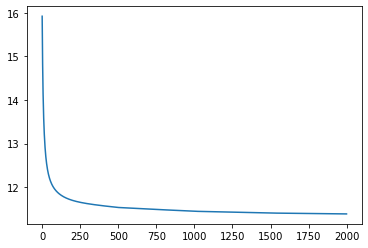

2022-04-26-w01-NP1


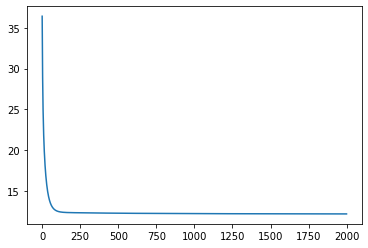

2021-12-03-w00-NP1


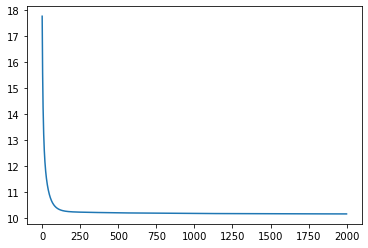

2022-02-22-w04-NP1


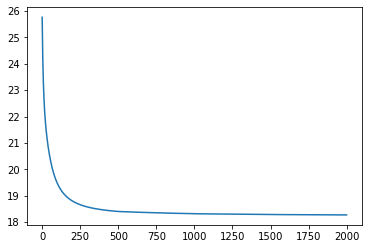

2022-04-01-w00-NP1


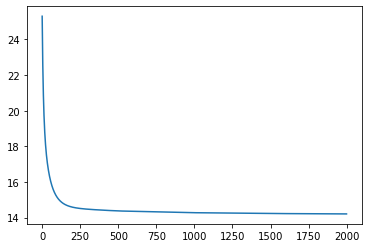

2022-03-05-w00-NP1


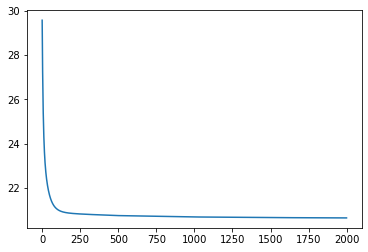

2022-02-12-w00-NP1


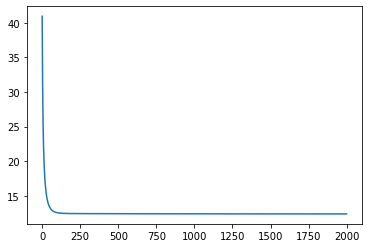

2022-02-12-w01-NP1


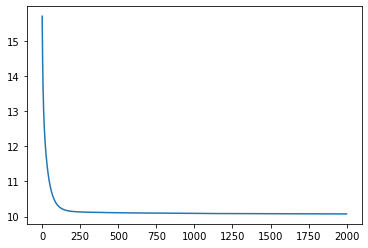

2022-01-22-w04-NP1


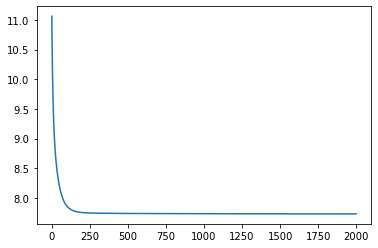

2022-02-11-w03-NP1


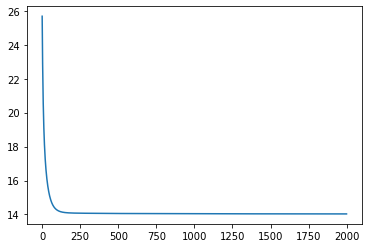

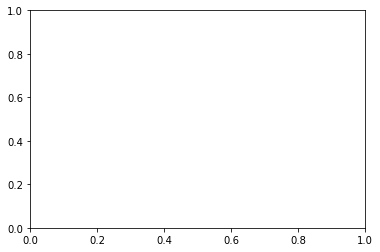

In [44]:
%matplotlib inline
results = pd.DataFrame()
trans_dict = {}

neur_dict = atlas.create_dictionary()

for folder in os.listdir('data/NP_FOCO_hist'):
    if folder == '.DS_Store':
        continue

    print(folder)

    df_data, RGBW = get_zscore_data('data/NP_FOCO_hist/'+folder)

    losses, A, b, df_data = learn_transform(df_data, neur_dict, alpha = 0.001)

    trans_data = transform(df_data, A, b)
    trans_dict[folder] = trans_data
    
    base_xyz, base_rgb = uti.calc_costs(df_atlas, atlas.sigma, df_data)
    trans_xyz, trans_rgb = uti.calc_costs(df_atlas, atlas.sigma, trans_data)

    results = results.append({'folder':folder, 'base_xyz': base_xyz, 'base_rgb':base_rgb, 'trans_xyz':trans_xyz, 'trans_rgb':trans_rgb, 'A':A, 'b':b}, ignore_index=True)

    trans_data.to_csv('data/NP_FOCO_trans_med/'+folder+'/trans_data.csv',index=False)

    #trans_RGBW = RGBW @ A + b
    
    #sio.savemat('data/NP_FOCO_trans_med/'+folder+'/'+'trans_data.mat', {'trans_data':trans_data})

    plt.plot(losses)
    plt.show()
    plt.cla()

In [13]:
df_data, RGBW = get_zscore_data('data/NP_FOCO_hist/2022-02-12-w01-NP1')

losses, A, b, df_data = learn_transform(df_data, neur_dict, alpha = 0.001)

trans_data = transform(df_data, A, b)

base_xyz, base_rgb = uti.calc_costs(df_atlas, atlas.sigma, df_data)
trans_xyz, trans_rgb = uti.calc_costs(df_atlas, atlas.sigma, trans_data)

trans_data.to_csv('data/NP_FOCO_trans/2022-02-12-w01-NP1/trans_data.csv',index=False)

sio.savemat('data/NP_FOCO_trans/2022-02-12-w01-NP1/'+'trans_data.mat', {'trans_data':trans_data})

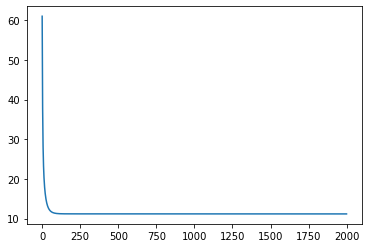

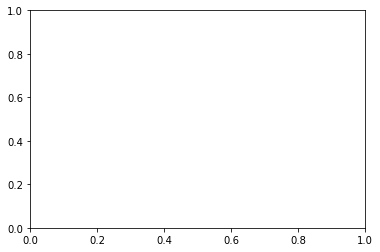

In [38]:
df_data, RGBW = get_zscore_data('data/NP_FOCO_hist/2022-02-12-w00-NP1')

losses, A, b, df_data = learn_transform(df_data, neur_dict, alpha = 0.001)

trans_data = transform(df_data, A, b)
trans_dict[folder] = trans_data

base_xyz, base_rgb = uti.calc_costs(df_atlas, atlas.sigma, df_data)
trans_xyz, trans_rgb = uti.calc_costs(df_atlas, atlas.sigma, trans_data)

results = results.append({'folder':folder, 'base_xyz': base_xyz, 'base_rgb':base_rgb, 'trans_xyz':trans_xyz, 'trans_rgb':trans_rgb, 'A':A, 'b':b}, ignore_index=True)

trans_data.to_csv('data/NP_FOCO_trans/2022-02-12-w00-NP1/trans_data.csv',index=False)


plt.plot(losses)
plt.show()
plt.cla()